In [287]:
#!pip install pyephem

import ephem
from astropy.coordinates import solar_system
from astropy import time
from astropy.coordinates import SkyCoord
import astroquery.heasarc

import astropy.units as u
import astropy.coordinates as coord
import numpy as np

import matplotlib as mpl
import matplotlib.pylab as plt

import gzip

In [47]:
if False:
    # this is slow, 5-10min
    H = astroquery.heasarc.Heasarc()

    with astroquery.heasarc.Conf.server.set_temp('https://www.isdc.unige.ch/browse/w3query.pl'):
        R = H.query_object('Crab', mission='integral_rev3_scw', resultmax=1000000, radius="1000 deg", cache=False,
                               time="2001-01-01 .. 2021-01-01",
                               fields='All',
                               good_isgri=">1000",
                               scw_type="POINTING"

           )

    print("writing...")
    R.to_pandas().to_csv(open("archive.csv", "w"))
    
    R.sort('SCW_ID')
    R
else:
    #read
    pass

In [183]:
R

SCW_ID,SCW_VER,SCW_TYPE,RA_X,DEC_X,START_DATE,END_DATE,OBS_ID,OBS_TYPE,PS,PI_NAME,GOOD_SPI,GOOD_PICSIT,GOOD_ISGRI,GOOD_JEMX,GOOD_JEMX1,GOOD_JEMX2,GOOD_OMC,DSIZE,RA_Z,DEC_Z,POSANGLE,OBT_START,OBT_END,IJD_START,IJD_END,SPIMODE,IBISMODE,JMX1MODE,JMX2MODE,OMCMODE,EXP_ID,CREA_DT,ING_DT,_SEARCH_OFFSET
,,,,,ISO,ISO,,,,,,,,,,,,,,,,,,,,,,,,,,ISO,ISO,
bytes12,bytes7,bytes8,bytes10,bytes10,bytes19,bytes19,bytes74,bytes13,bytes7,bytes91,bytes8,bytes11,bytes10,bytes9,bytes10,bytes10,bytes8,bytes9,bytes20,bytes22,bytes19,bytes20,bytes20,bytes16,bytes16,bytes7,bytes8,bytes8,bytes8,bytes7,bytes8,bytes19,bytes19,float64
000752000030,001,POINTING,149.840576,-0.982139,2002-11-04 03:21:48,2002-11-04 05:51:48,,,PUBLIC,,0,144,4860,8998,8998,8953,9000,63122432,240.120056152344,-15.8811941146851,-105.883589799405,1637161631744,1646598815744,1038.14088030571,1038.24504702123,31,98,41,41,21,,2004-09-24 13:33:26,2004-09-27 13:33:26,4106.193
000853000010,001,POINTING,149.840500,-0.982444,2002-11-06 19:56:20,2002-11-06 22:26:20,,,PUBLIC,,3433,8805,8873,8544,8544,8535,9000,298470400,240.12483215332,-16.1407222747803,-106.143159863528,1880926191616,1890363375616,1040.83152973559,1040.93569645243,41,41,41,41,21,,2004-09-16 18:02:29,2004-09-19 18:02:29,4106.196
000853000020,001,POINTING,149.840454,-0.982611,2002-11-06 22:26:20,2002-11-07 00:56:20,,,PUBLIC,,3425,8146,9000,8759,8758,8759,9000,298726400,240.124740600586,-16.1340007781982,-106.136438652966,1890363375616,1899800559616,1040.93569645243,1041.0398631693,41,41,41,41,21,,2004-09-16 18:07:30,2004-09-19 18:07:30,4106.198
000853000030,001,POINTING,149.840454,-0.982639,2002-11-07 00:56:20,2002-11-07 03:26:20,,,PUBLIC,,3418,8676,9000,7911,7911,7910,9000,298860544,240.124633789062,-16.1277770996094,-106.130214134459,1899800559616,1909237743616,1041.0398631693,1041.14402988621,41,41,98,98,21,,2004-09-16 18:08:49,2004-09-19 18:08:49,4106.198
000853000040,001,POINTING,149.840500,-0.982750,2002-11-07 03:26:20,2002-11-07 05:56:20,,,PUBLIC,,3414,8017,9000,8728,8728,8718,9000,298857472,240.124603271484,-16.1212215423584,-106.123658313559,1909237743616,1918674927616,1041.14402988621,1041.24819660315,41,41,41,41,21,,2004-09-16 18:10:57,2004-09-19 18:10:57,4106.204
000853000050,001,POINTING,149.840454,-0.982833,2002-11-07 05:56:20,2002-11-07 08:26:20,,,PUBLIC,,3409,8547,8998,8296,8295,8296,9000,299772928,240.124420166016,-16.1139450073242,-106.116380582869,1918674927616,1928112111616,1041.24819660315,1041.35236332012,41,41,41,41,21,,2004-09-16 18:11:43,2004-09-19 18:11:43,4106.203
000853000070,001,POINTING,98.264046,-53.380138,2002-11-07 10:56:20,2002-11-07 13:26:20,,,PUBLIC,,1229,2713,3239,3035,3035,3014,0,291931136,219.384368896484,-21.0125274658203,-126.95041893607,1937549295616,1946986479616,1041.45653003711,1041.56069675406,41,41,41,41,98,,2004-09-17 14:04:47,2004-09-20 14:04:47,4587.235
000853000080,001,POINTING,99.322456,-54.216862,2002-11-07 13:26:20,2002-11-07 15:56:20,,,PUBLIC,,1200,2721,2963,2977,2977,2976,0,283085824,219.926788330078,-20.1506938934326,-126.097098377756,1946986479616,1956423663616,1041.56069675406,1041.66486347117,41,41,98,98,98,,2004-09-17 14:03:58,2004-09-20 14:03:58,4645.192


In [186]:
scx_coord = coord.SkyCoord(R['RA_X'], R['DEC_X'], unit="deg")

In [184]:
"total good ISGRI:", r['GOOD_ISGRI'].astype(float).sum()/1e6

442.810196

In [200]:
def get_body_coord_pyephem(body_name):
    # this is faster than astropy, result is identical
    body = getattr(ephem, body_name)()

    body_ra = []
    body_dec = []
    for t1,t2 in zip(R['START_DATE'], R['END_DATE']):
        body.compute(t1) 
        body_ra.append(body.ra/np.pi*180)
        body_dec.append(body.dec/np.pi*180)
    
    return coord.SkyCoord(body_ra, body_dec, unit='deg')

In [191]:
def get_body_coord_astropy(body_name):
    return solar_system.get_body(body_name, 
                                 time.Time(R['IJD_START'].astype(float) + 51544, format="mjd"))


In [280]:

def total_flux_sensivity(c, lim_deg=10):
    sep=c.separation(scx_coord).deg
    m = sep < lim_deg    
    
    isgri_sensitivity_25_80_keV_1sigma_2ks = 1e-8 * u.erg/u.cm**2/u.s * (1./2000.)

    sens = (c.distance.to(u.cm)[m]**2 * isgri_sensitivity_25_80_keV_1sigma_2ks * (R['GOOD_ISGRI'][m].astype(float)/200)**0.5).to(u.erg/u.s)

    sens_combined = np.sum((sens**-2))**-0.5 # weighed mean uncertainty

    return sens_combined
    

In [414]:
body_names = ['Venus', 'Sun', 'Mars', 'Mercury', 'Jupiter', 'Saturn', 'Uranus', 'Neptune', 'Pluto']

==================================================Venus
found 0.174117 Ms in 85 pointings of Venus good ISGRI observations within 10 deg


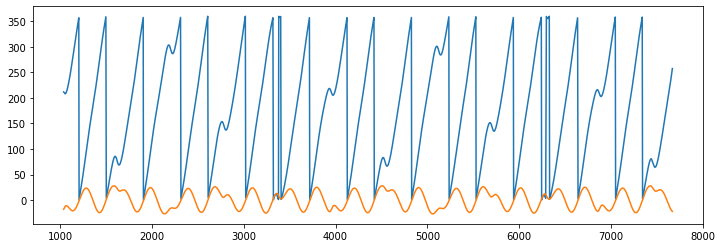

found 0.168514 Ms in 81 pointings of Venus good ISGRI observations within 10 deg


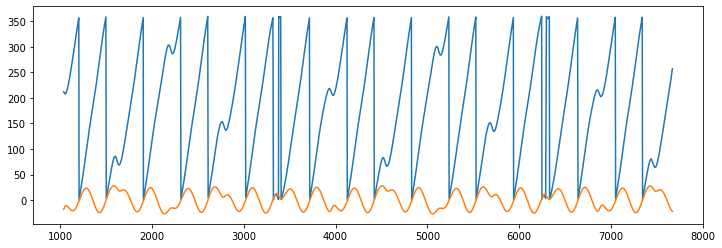

total flux sensitivity to Venus is 2.02e+15 erg/s
==================================================Sun
found 0.0 Ms in 0 pointings of Sun good ISGRI observations within 10 deg
Sun was not observed, which is good!


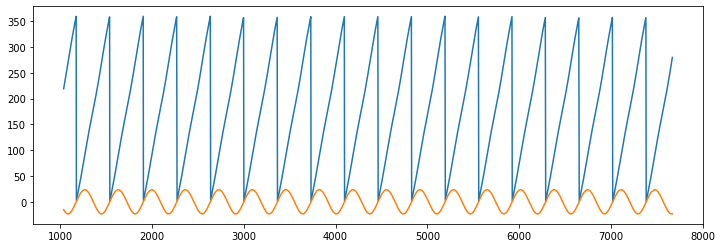

found 0.0 Ms in 0 pointings of Sun good ISGRI observations within 10 deg
Sun was not observed, which is good!


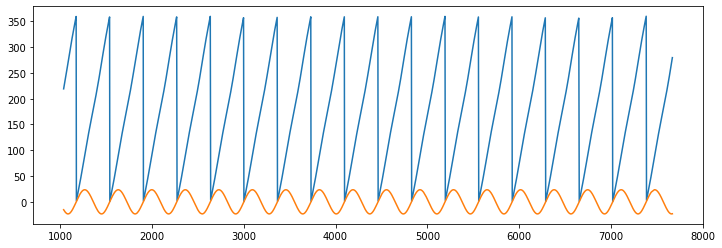

/home/savchenk/.pyenv/versions/3.8.6/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


total flux sensitivity to Sun is    inf erg/s
==================================================Mars
found 3.763564 Ms in 1596 pointings of Mars good ISGRI observations within 10 deg


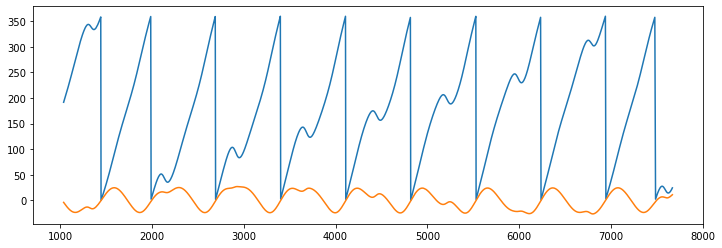

found 3.744135 Ms in 1588 pointings of Mars good ISGRI observations within 10 deg


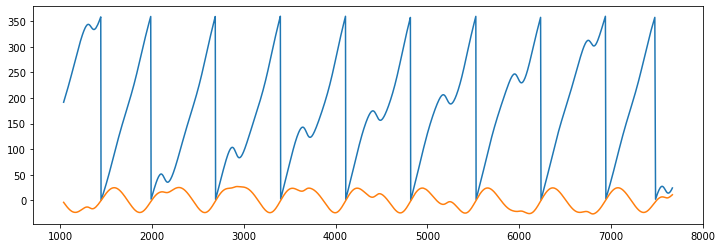

total flux sensitivity to Mars is 1.15e+15 erg/s
==================================================Mercury
found 0.0 Ms in 0 pointings of Mercury good ISGRI observations within 10 deg


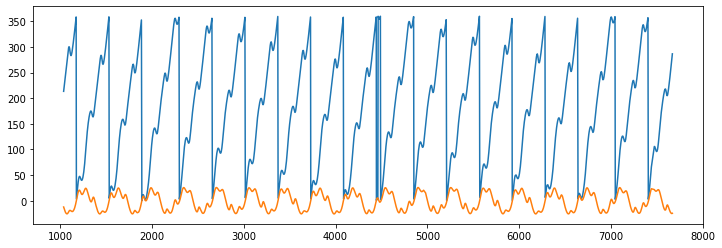

found 0.0 Ms in 0 pointings of Mercury good ISGRI observations within 10 deg


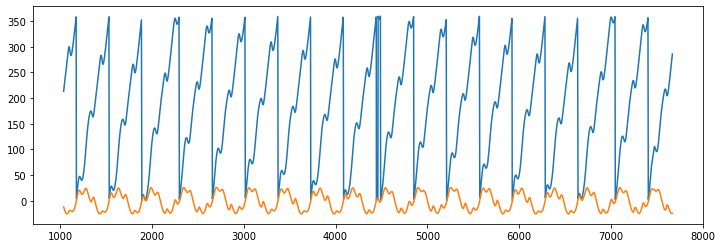

/home/savchenk/.pyenv/versions/3.8.6/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


total flux sensitivity to Mercury is    inf erg/s
==================================================Jupiter
found 4.412807 Ms in 1877 pointings of Jupiter good ISGRI observations within 10 deg


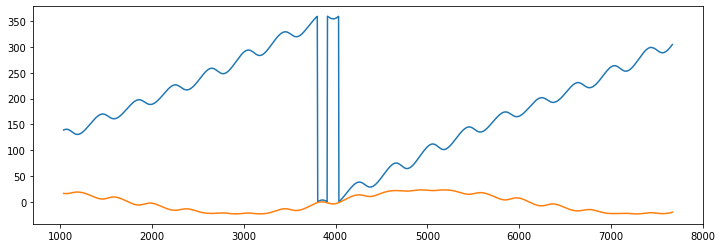

found 4.360247 Ms in 1853 pointings of Jupiter good ISGRI observations within 10 deg


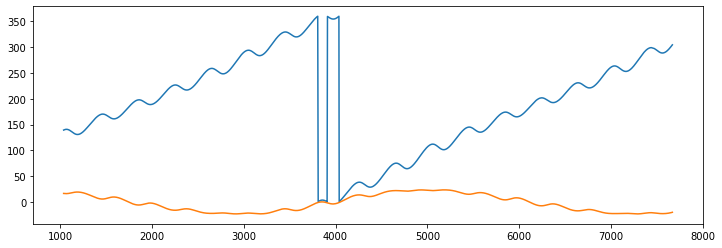

total flux sensitivity to Jupiter is 2.18e+16 erg/s
==================================================Saturn
found 8.978899 Ms in 3181 pointings of Saturn good ISGRI observations within 10 deg


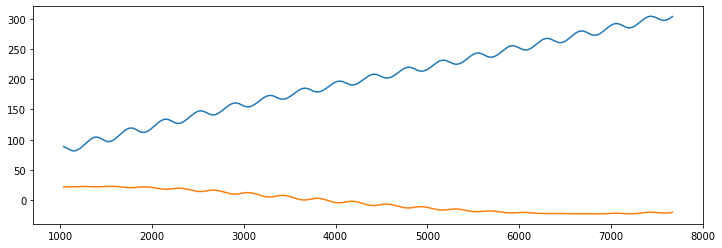

found 9.066307 Ms in 3207 pointings of Saturn good ISGRI observations within 10 deg


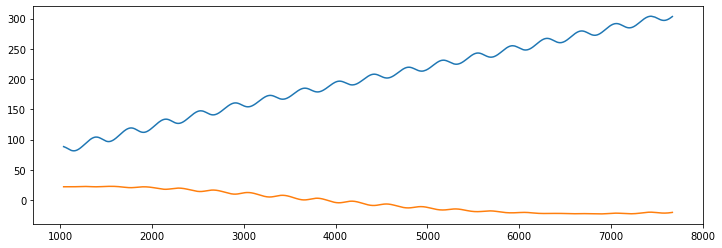

total flux sensitivity to Saturn is 6.49e+16 erg/s
==================================================Uranus
found 0.174691 Ms in 68 pointings of Uranus good ISGRI observations within 10 deg


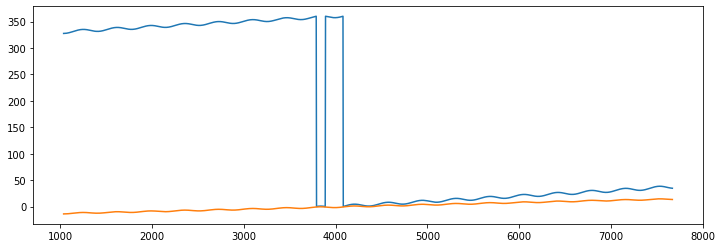

found 0.17205 Ms in 67 pointings of Uranus good ISGRI observations within 10 deg


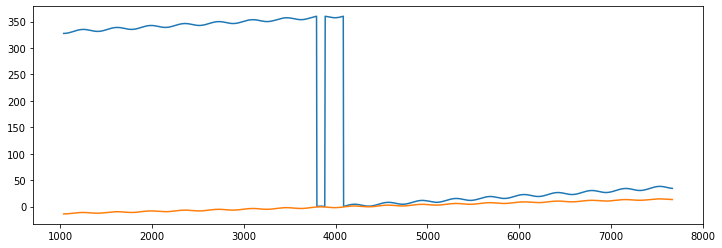

total flux sensitivity to Uranus is 1.86e+18 erg/s
==================================================Neptune
found 0.182509 Ms in 61 pointings of Neptune good ISGRI observations within 10 deg


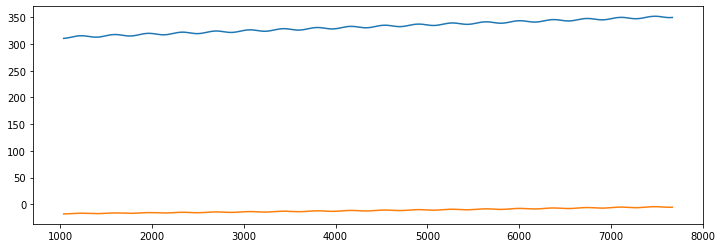

found 0.182509 Ms in 61 pointings of Neptune good ISGRI observations within 10 deg


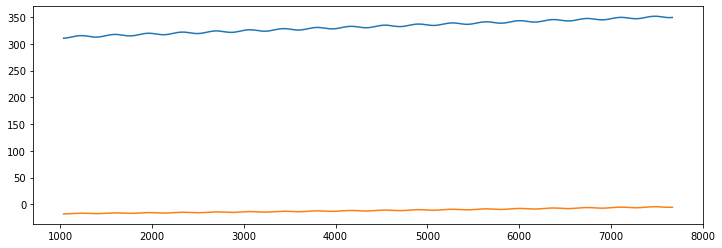

total flux sensitivity to Neptune is 4.75e+18 erg/s
==================================================Pluto
found 8.682008 Ms in 3813 pointings of Pluto good ISGRI observations within 10 deg


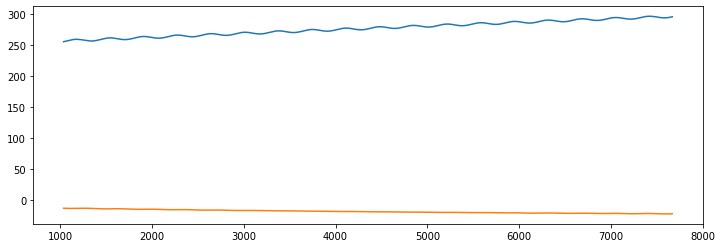

failed to distance astropy!


In [396]:
def find_body_in_fov(body_name, lim_deg=10, f=get_body_coord_pyephem, plot=True):
    c = f(body_name)

    sep=c.separation(scx_coord).deg
    m = sep < lim_deg
    on_isgri = np.sum(R['GOOD_ISGRI'].astype(float)[m])/1e6
    print(f"found {on_isgri} Ms in {np.sum(m)} pointings of {body_name} good ISGRI observations within {lim_deg} deg")
    
    if body_name == "Sun":
        if np.sum(m) == 0:
            print("Sun was not observed, which is good!")
        else:
            print("\033[31mwarning! sun was observed??\033[0m")
            #raise RuntimeError
    
    if plot:
        plt.figure(figsize=(12,4))

        plt.plot(
            R['IJD_START'][::100].astype(float),
            c.ra[::100],
        )
        plt.plot(
            R['IJD_START'][::100].astype(float),
            c.dec[::100],
        )

        
        plt.title('')

        plt.show()
    

    return c, m, on_isgri, np.sum(m)

fast_way = False

summary_by_body={}

for body_name in ['Venus', 'Sun', 'Mars', 'Mercury', 'Jupiter', 'Saturn', 'Uranus', 'Neptune', 'Pluto']:
    D = {}
    summary_by_body[body_name] = D
    
    print(f"\033[41m{'='*100}\033[0m")
    print(f"\033[41m{'='*50}\033[1;42m{body_name}\033[0m")
    c, m, on_isgri, n_point = find_body_in_fov(body_name)
    if not fast_way:
        try:
            c, m, on_isgri, n_point = find_body_in_fov(body_name, f=get_body_coord_astropy)
            sens_combined = total_flux_sensivity(c)        
            print(f"total flux sensitivity to {body_name} is {sens_combined.to(u.erg/u.s).value:6.3g} erg/s")
            
            D["sensitivity_erg_s"] = sens_combined.to(u.erg/u.s).value            
            distance_cm = c.distance.cm
        except KeyError:
            print("failed to distance astropy!")
            distance_cm = np.inf
            
        D["on_isgri_Ms"] = on_isgri
        D["on_pointings"] = n_point
        R[f'{body_name}_ra'] = c.ra.deg
        R[f'{body_name}_dec'] = c.dec.deg
        R[f'{body_name}_distance_cm'] = distance_cm



In [307]:
R.to_pandas().to_csv("archive-with-bodies.csv.gz", compression='gzip')

In [448]:
import astropy.time as time

T = time.Time(R['IJD_START'].astype(float) + 51544, format="mjd").to_datetime()


In [457]:
Sun_coord = coord.SkyCoord(R["Sun_ra"], R["Sun_dec"], unit="deg")

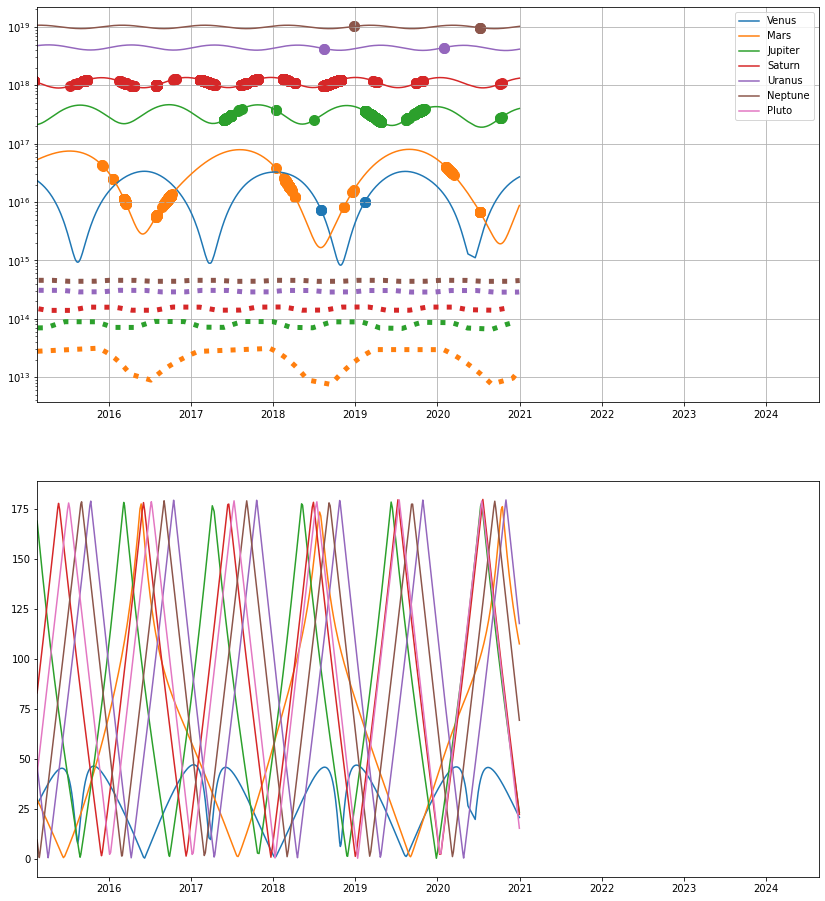

In [522]:

#plt.figure(figsize=(14,10))
f, (ax, ax2) = plt.subplots(2,1,figsize=(14,16))

for body_name in body_names:
    if body_name in ['Sun', 'Mercury']:
        continue
        
    sens_ecs = ((R[body_name+"_distance_cm"]*u.cm)**2 * isgri_sensitivity_25_80_keV_1sigma_2ks).to(u.erg/u.s)
    
    p = ax.plot(
        T[::100],
        sens_ecs[::100],
        label=body_name,
    )
    
    C = coord.SkyCoord(R[body_name + "_ra"], R[body_name + "_dec"], unit="deg")
    D_deg = C.separation(scx_coord).deg
    
    Sun_angle_deg = Sun_coord.separation(C).deg
    m_sun_angle = Sun_angle_deg > (90 - 40)
    m_sun_angle &= Sun_angle_deg < (90 + 40)
    
    ax.plot(
        T[m_sun_angle][::100],
        R[body_name+"_distance_cm"][m_sun_angle][::100].astype(float),
        #label=body_name,
        #s=10,
        lw=5,
        ls=":",
        c=p[0].get_color(),
    )
    
    m = R['GOOD_ISGRI'].astype(float) > 1000
    m &= D_deg < 10
    
    ax.scatter(
        T[m],
        sens_ecs[m],
        c=p[0].get_color(),
        s=100,
        marker="o",
        #label=body_name,
    )

    p = ax2.plot(
        T[::100],
        Sun_angle_deg[::100],
     #   label=body_name,
        c=p[0].get_color(),
    )
    
ax.legend()
    
ax.semilogy()

ax.set_xlim([T[-50000],time.Time(9000+51544,format="mjd").to_datetime()])
ax2.set_xlim([T[-50000],time.Time(9000+51544,format="mjd").to_datetime()])

ax.grid()

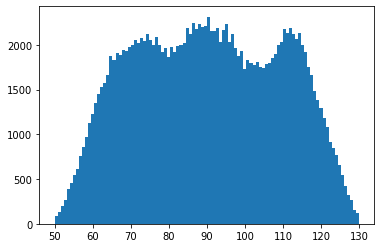

In [515]:
plt.figure()

# the reason why venus is rare is because of solar angle. inner planets have that restriction
# ISGRI has extra 10 deg for off-axis pointing, if designed
# it is never possible to observe Venus
# https://en.wikipedia.org/wiki/Elongation_(astronomy) of venus is up to 47 deg

_=plt.hist(
    Sun_coord.separation(scx_coord).deg,
    100
)

plt.axvline()

the reason why venus is rare is because of solar angle. inner planets have that restriction
ISGRI has extra 10 deg for off-axis pointing, if designed

In [400]:
import json

#json.dump(summary_by_body, open("summary_by_body.json", "wt"), indent=4)

summary_by_body

{'Venus': {'sensitivity_erg_s': 2023918343384943.8,
  'on_isgri_Ms': 0.168514,
  'on_pointings': 81},
 'Sun': {'sensitivity_erg_s': inf, 'on_isgri_Ms': 0.0, 'on_pointings': 0},
 'Mars': {'sensitivity_erg_s': 1151191493617938.0,
  'on_isgri_Ms': 3.744135,
  'on_pointings': 1588},
 'Mercury': {'sensitivity_erg_s': inf, 'on_isgri_Ms': 0.0, 'on_pointings': 0},
 'Jupiter': {'sensitivity_erg_s': 2.182728445837121e+16,
  'on_isgri_Ms': 4.360247,
  'on_pointings': 1853},
 'Saturn': {'sensitivity_erg_s': 6.4927958799684536e+16,
  'on_isgri_Ms': 9.066307,
  'on_pointings': 3207},
 'Uranus': {'sensitivity_erg_s': 1.855665674969776e+18,
  'on_isgri_Ms': 0.17205,
  'on_pointings': 67},
 'Neptune': {'sensitivity_erg_s': 4.746794849613064e+18,
  'on_isgri_Ms': 0.182509,
  'on_pointings': 61},
 'Pluto': {'on_isgri_Ms': 8.682008, 'on_pointings': 3813}}

In [411]:
pd.DataFrame([{'name':k, 'known_typical_lum': reference_object_erg_s.get(k, 0), **v} for k, v in summary_by_body.items()])

,name,known_typical_lum,sensitivity_erg_s,on_isgri_Ms,on_pointings
0,Venus,5.500000e+14,2.023918e+15,0.168514,81
1,Sun,0.000000e+00,inf,0.000000,0
2,Mars,4.000000e+13,1.151191e+15,3.744135,1588
3,Mercury,0.000000e+00,inf,0.000000,0
4,Jupiter,2.200000e+16,2.182728e+16,4.360247,1853
5,Saturn,8.700000e+14,6.492796e+16,9.066307,3207
6,Uranus,6.000000e+15,1.855666e+18,0.172050,67
7,Neptune,1.200000e+16,4.746795e+18,0.182509,61
8,Pluto,2.000000e+15,NaN,8.682008,3813


In [403]:
for o, d in summary_by_body.items():
    print(f"{o}")
    try:
        print(f" : known value {reference_object_erg_s[o]:5.3g} archive 1 sigma limit {d['sensitivity_erg_s']:5.4g} erg/s")
        print(f" : typical known value / 1 sigma limit in archive /  {reference_object_erg_s[o]/d['sensitivity_erg_s']:5.3g}")
        print(f" : potential for exposure improvement (400ks) {0.4/d['on_isgri_Ms']:5.3g}")    
        print(f" : typical known value / ToO limit /  {reference_object_erg_s[o]/(d['sensitivity_erg_s']/(0.4/d['on_isgri_Ms'])**0.5):5.3g}")
    except:
        print("nope")

Venus
 : known value 5.5e+14 archive 1 sigma limit 2.024e+15 erg/s
 : typical known value / 1 sigma limit in archive /  0.272
 : potential for exposure improvement (400ks)  2.37
 : typical known value / ToO limit /  0.419
Sun
nope
Mars
 : known value 4e+13 archive 1 sigma limit 1.151e+15 erg/s
 : typical known value / 1 sigma limit in archive /  0.0347
 : potential for exposure improvement (400ks) 0.107
 : typical known value / ToO limit /  0.0114
Mercury
nope
Jupiter
 : known value 2.2e+16 archive 1 sigma limit 2.183e+16 erg/s
 : typical known value / 1 sigma limit in archive /   1.01
 : potential for exposure improvement (400ks) 0.0917
 : typical known value / ToO limit /  0.305
Saturn
 : known value 8.7e+14 archive 1 sigma limit 6.493e+16 erg/s
 : typical known value / 1 sigma limit in archive /  0.0134
 : potential for exposure improvement (400ks) 0.0441
 : typical known value / ToO limit /  0.00281
Uranus
 : known value 6e+15 archive 1 sigma limit 1.856e+18 erg/s
 : typical known 

In [360]:
import requests
import re

t = requests.get("https://heasarc.gsfc.nasa.gov/docs/heasarc/headates/what_kind.html").text
table = re.search("<pre>(.*?)</pre>", t, re.M | re.S).groups()[0]
table = re.sub(" - [0-9]\.[0-9]E[0-9]+? ", " "*8, table).replace("<"," ")
print(table)


Object      Lx (erg/s)        Lx (SI)        Comments

Moon        7.3E11            73 kW
Europa      1.5E13            1.5 MW

Io          2.0E13            2 MW
Mars        4.0E13          4 - 16 MW
Comets      1.0E14          10 - 5000 MW   Within 2 Au of the Sun
Earth       3.0E14            30 MW          My guess
Venus       5.5E14            55 MW
Saturn      8.7E14            87 MW
Io Plasma   1.0E15            100 MW
Torus
Pluto       2.0E15            200 MW         Surprisingly large!
Uranus      6.0E15            600 MW
Neptune     1.2E16           1200 MW
Jupiter     2.2E16           2200 MW



In [370]:
import pandas as pd
import io
d = pd.read_fwf(io.StringIO(table), header=1)
d['Lx_erg_s'] = d['Lx (erg/s)'].astype(float)

reference_object_erg_s = dict(zip(d['Object'], d['Lx_erg_s']))
reference_object_erg_s

{nan: nan,
 'Moon': 730000000000.0,
 'Europa': 15000000000000.0,
 'Io': 20000000000000.0,
 'Mars': 40000000000000.0,
 'Comets': 100000000000000.0,
 'Earth': 300000000000000.0,
 'Venus': 550000000000000.0,
 'Saturn': 870000000000000.0,
 'Io Plasma': 1000000000000000.0,
 'Torus': nan,
 'Pluto': 2000000000000000.0,
 'Uranus': 6000000000000000.0,
 'Neptune': 1.2e+16,
 'Jupiter': 2.2e+16}